<a href="https://colab.research.google.com/github/NatashaKamami/Music-Recommendation-System/blob/main/Music_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Manipulation libraries
import pandas as pd
import numpy as np

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Handling libraries
import spacy
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Scikit Learn libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [2]:
# Loading the dataset
songs_data = pd.read_csv('/content/music_data.csv')

songs_data.head()

,song_id,name,artist,album,popularity,youtube_url,tempo,energy,spectral_rolloff,chroma,danceability
0,2plbrEY59IikOBgBGLjaoe,Die With A Smile,Lady Gaga,Die With A Smile,100,https://www.youtube.com/watch?v=kPa7bsKwL-c,151.999081,0.275263,4553.724520,0.206741,0.685975
1,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,Billie Eilish,HIT ME HARD AND SOFT,97,https://www.youtube.com/watch?v=d5gf9dXbPi0,103.359375,0.473026,4111.013014,0.377576,0.199982
2,0WbMK4wrZ1wFSty9F7FCgu,"Good Luck, Babe!",Chappell Roan,"Good Luck, Babe!",92,https://www.youtube.com/watch?v=1RKqOmSkGgM,117.453835,0.436596,4749.354118,0.240505,0.203657
3,5G2f63n7IPVPPjfNIGih7Q,Taste,Sabrina Carpenter,Short n' Sweet,90,https://www.youtube.com/watch?v=z9Q9OzL_wI8,112.347147,0.515997,6210.176734,0.330740,0.238436
4,7tI8dRuH2Yc6RuoTjxo4dU,Who,Jimin,MUSE,90,https://www.youtube.com/watch?v=dk7NkMLYAis,117.453835,0.547213,7159.904111,0.291583,0.258594


##**EDA**

In [3]:
# Overview of the data
songs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310 entries, 0 to 3309
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           3310 non-null   object 
 1   name              3310 non-null   object 
 2   artist            3310 non-null   object 
 3   album             3310 non-null   object 
 4   popularity        3310 non-null   int64  
 5   youtube_url       3310 non-null   object 
 6   tempo             3310 non-null   float64
 7   energy            3310 non-null   float64
 8   spectral_rolloff  3310 non-null   float64
 9   chroma            3310 non-null   float64
 10  danceability      3310 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 284.6+ KB


### **1. Summary Statistics**

In [4]:
# summary statistics of the numeric columns
songs_data.describe()

,popularity,tempo,energy,spectral_rolloff,chroma,danceability
count,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000
mean,43.807855,123.188168,0.390884,5013.401322,0.392590,0.313301
std,26.110245,20.710912,0.139046,1031.373963,0.132271,0.152986
min,0.000000,69.837416,0.000000,898.006290,0.000000,0.000000
25%,24.000000,107.666016,0.292697,4343.417942,0.304216,0.201590
50%,48.500000,123.046875,0.400734,5005.573988,0.380102,0.288592
75%,65.000000,135.999178,0.486272,5676.675645,0.467313,0.397850
max,100.000000,198.768029,1.000000,8206.093001,1.000000,1.000000


### **2. Correlation heatmap**

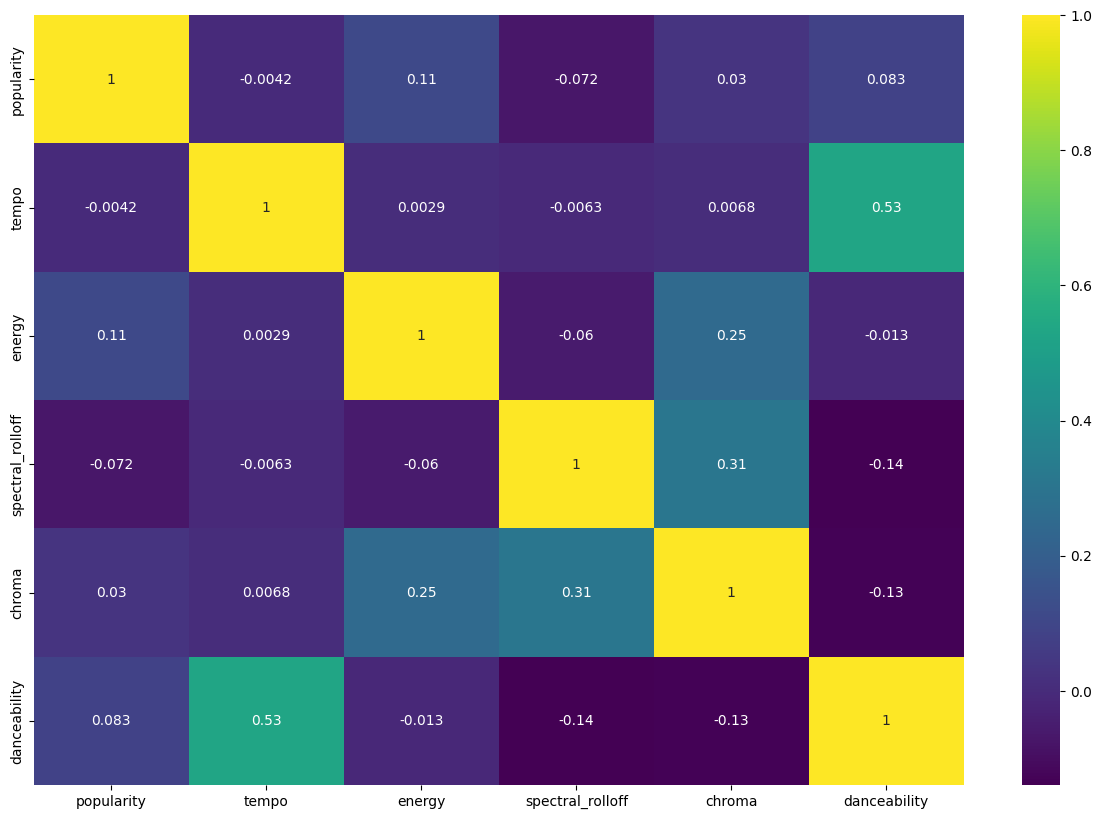

In [5]:
# Heatmap to show correlation between factors
plt.figure(figsize=(15,10))
sns.heatmap(songs_data.corr(numeric_only=True),annot=True,cmap='viridis')
plt.show()

**Insights :**
- There exists a strong positive relationship between tempo and danceability which means that songs with higher tempo/BPM tend to have higher danceability while slower songs are less suited for dancing.

- Similarly, energy and chroma also have a positive relationship which suggests that high energy tracks tend to also have high melodic structure and vice versa.

- Another notable relationship is the positive relationship between chroma and spectral roll-off meaning that songs with high spectral rolloff (frequency content) tend to have higher chroma (melodic structure/ intensity of pitches). This means that higher frequencies imply high-pitched sounds and vice versa.

- In contrast, a negative relationship exists between chroma and danceability meaning that songs with lower chroma values i.e songs relying more on beats and rhythm than melody, possess higher danceability and vice versa.


### **3. Distribution of popularity**

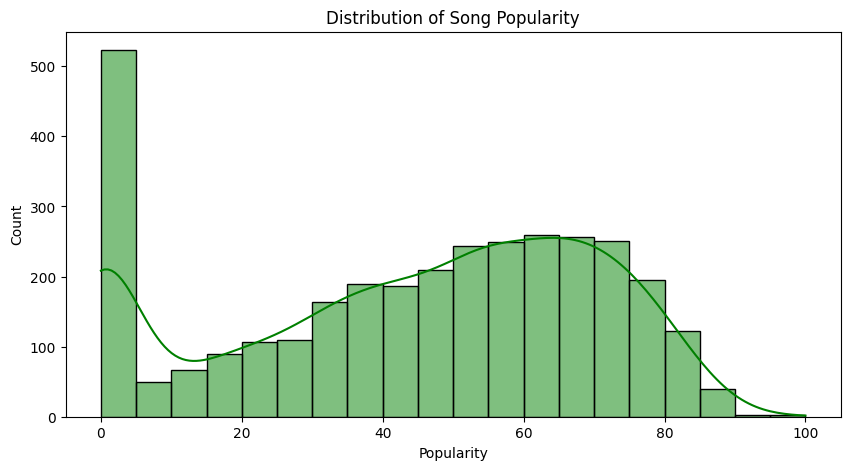

In [6]:
# Popularity Distribution
plt.figure(figsize=(10, 5))
sns.histplot(songs_data['popularity'], bins=20, kde=True, color='green')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

**Insights :**

The distribution of song popularity is left-skewed, indicating that most songs in the dataset have high popularity scores. However, there is a noticeable presence of outliers, with a significant number of songs having a popularity score of 0. This could suggest presence of niche or unrecognized songs which may belong to lesser-known artists or presence of newly released tracks that might not have gained traction yet, leading to a popularity score of zero.



### **4. Popular Albums**





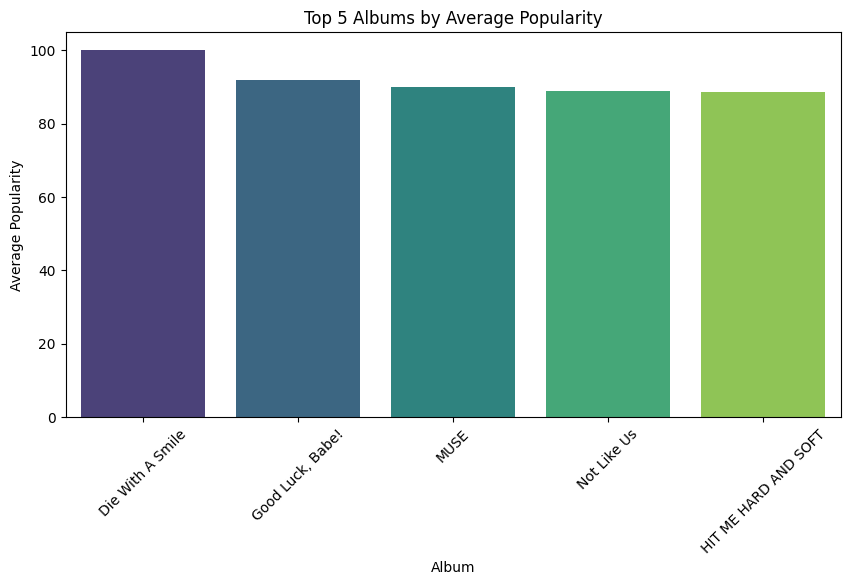

In [7]:
# Top 5 Albums by Average Popularity
plt.figure(figsize=(10, 5))
avg_popularity = songs_data.groupby('album')['popularity'].mean().nlargest(5)
sns.barplot(x=avg_popularity.index, y=avg_popularity.values, hue=avg_popularity.index,  palette='viridis')
plt.title('Top 5 Albums by Average Popularity')
plt.xlabel('Album')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.show()


**Insights :**

The plot highlights the top 5 albums with the highest average popularity in the dataset, suggesting that these albums may be critically acclaimed, commercially successful, or both. This could be as a result of:

1. These albums may contain multiple chart-topping tracks that have gained widespread recognition and streams.  
2. The albums may be from globally recognized artists which tend to perform well due to their established fanbase.  
3. Some of these albums may have won awards or received critical praise, increasing their visibility and listener engagement.  



### **5. Artists with the most songs**

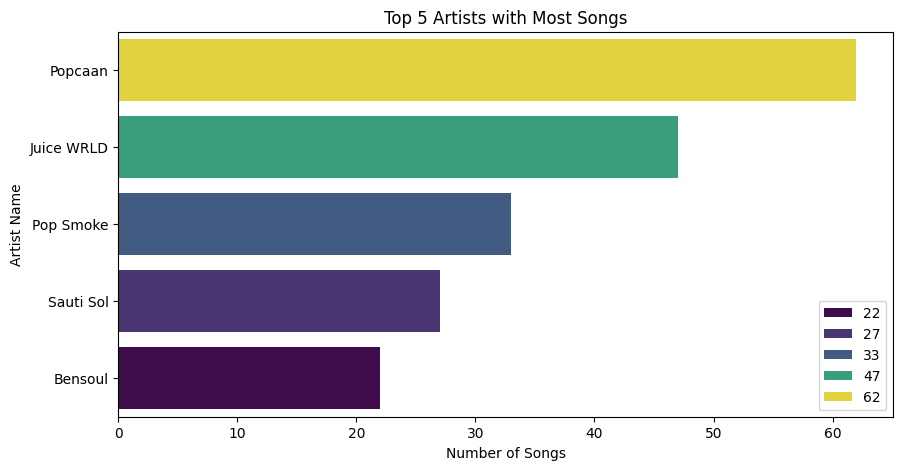

In [8]:
# Artists with the most songs
top_artists = songs_data['artist'].value_counts().nlargest(5)

# Plot the bar chart
plt.figure(figsize=(10, 5))
sns.barplot(y=top_artists.index,
            x=top_artists.values,
            hue=top_artists.values,
            palette='viridis')

plt.title('Top 5 Artists with Most Songs')
plt.xlabel('Number of Songs')
plt.ylabel('Artist Name')
plt.show()


**Insights :**

The visualization highlights the artists with the most tracks in the dataset, offering insights into their music release patterns and audience reach. Artists with a large number of songs may have long-standing careers, frequently release albums, or adopt high-output strategies such as remixes and collaborations. Additionally, a higher song count may indicate a strong fanbase and consistent streaming, even if not all tracks achieve chart-topping success. However, having many songs does not necessarily equate to high popularity across all releases. Further analysis could determine whether these artists maintain a high average popularity or if their success is driven by a few standout tracks.

### **6. Popularity of Artists with highest song counts**

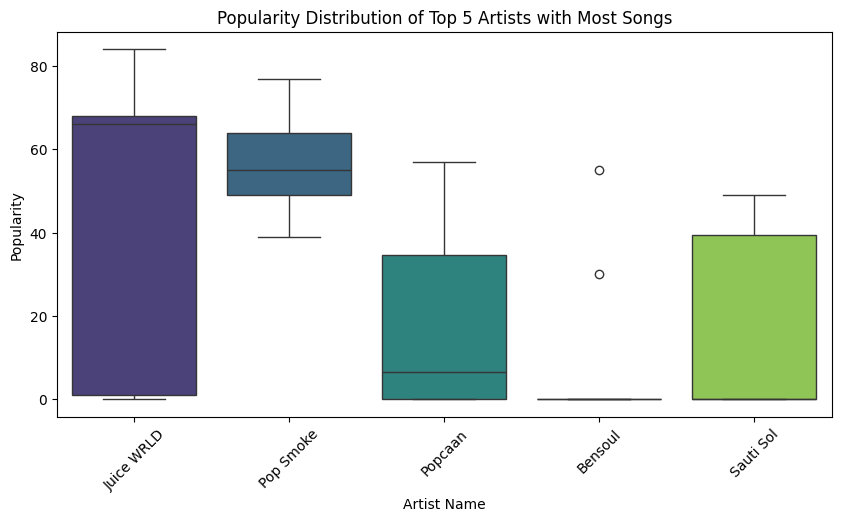

In [9]:
# Get the top 5 artists with the most songs
top_artists = songs_data['artist'].value_counts().nlargest(5).index

# Filter the dataset to include only the top 5 artists by song count
filtered_data = songs_data[songs_data['artist'].isin(top_artists)]

# Plot the boxplot for popularity distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='artist', y='popularity', data=filtered_data, hue='artist', palette='viridis')

plt.xlabel("Artist Name")
plt.ylabel("Popularity")
plt.title("Popularity Distribution of Top 5 Artists with Most Songs")
plt.xticks(rotation=45)
plt.show()


**Insights :**

The boxplot reveals the popularity distribution of the top five artists with the most songs in the dataset. Offering insights as to whether having a lot of songs translates to popularity/success.

- Juice WRLD exhibits a wide range of popularity scores, indicating that while he has many popular tracks, he also has several less popular ones. This suggests a diverse catalog with both major hits and lesser-known songs.
- Pop Smoke shows consistently high popularity scores with a median of close to 60, suggesting that most of his tracks perform well. This could be attributed to his mainstream appeal and continued posthumous success.
- Bensoul has a lower average popularity, but the presence of a few outliers suggests that while most of his songs have lower recognition, a few have gained significant attention. This could be due to viral hits or successful collaborations.
- Sauti Sol and Popcaan have a popularity range of between 0 to around 40, meaning their songs generally achieve moderate success. However, the presence of songs with higher popularity suggests that they have breakout tracks that perform significantly better than their usual releases.


### **7. Artists with highest average popularity**

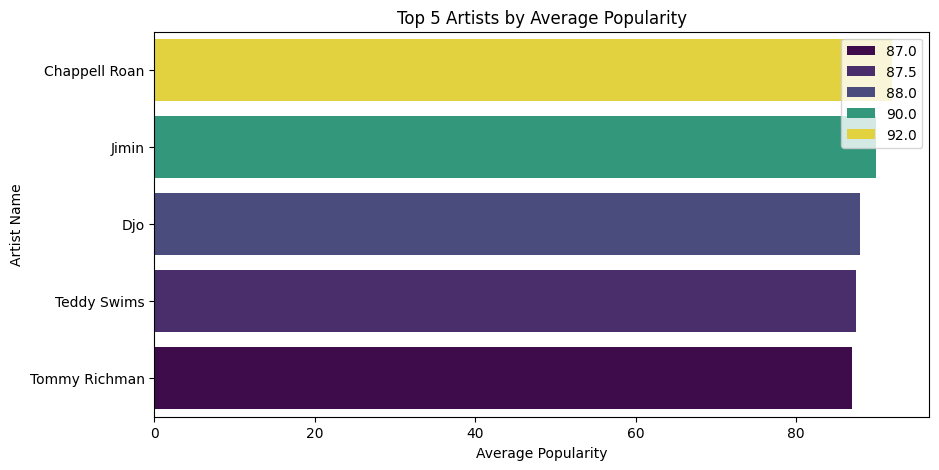

In [10]:
# Calculate average popularity per artist
top_artists_by_popularity = songs_data.groupby('artist')['popularity'].mean().nlargest(5)

# Plot the bar chart
plt.figure(figsize=(10, 5))
sns.barplot(y=top_artists_by_popularity.index,
            x=top_artists_by_popularity.values,
            hue=top_artists_by_popularity.values,
            palette='viridis')

plt.xlabel("Average Popularity")
plt.ylabel("Artist Name")
plt.title("Top 5 Artists by Average Popularity")
plt.show()


**Insights :**

This bar plot highlights the artists with the highest average song popularity. These artists likely have high listener engagement, strong fan loyalty, or a track record of releasing widely streamed hits.
A key takeaway is that the most prolific artists (those with the most songs in the dataset) are not necessarily the most popular on average. This suggests that quantity does not always equate to popularity. Some artists may focus on quality over volume, releasing fewer but highly successful songs.














### **8. Word cloud object**

In [11]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
data = pd.DataFrame(songs_data[['name']])

# Load Spacy model
nlp = spacy.load('en_core_web_sm')

#Function to clean the columns
def clean_text(text):

  #Convert text to lowercase
  text = text.lower()

  #Process text using spacy
  doc = nlp(text)

  #Lemmatization and removing stop words and punctuation
  cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

  return cleaned_text

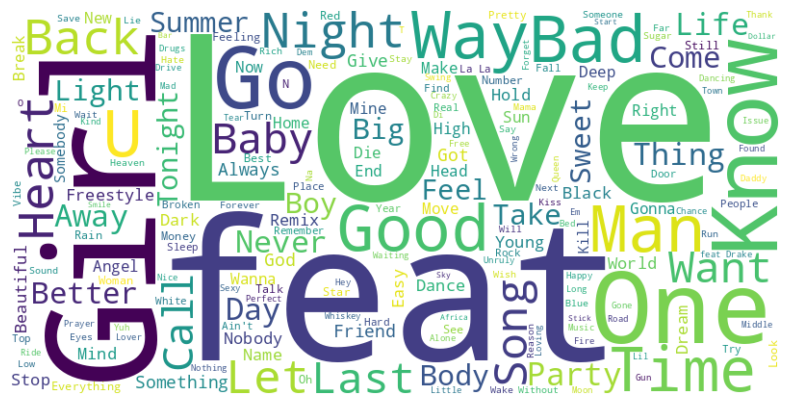

In [27]:
#Creating a word cloud
text = ' '.join(data['name'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Insights :**

The word cloud visualization helps identify recurring themes in song titles, with words like love, feat, and girl appearing frequently. This suggests that many songs in the dataset revolve around love, relationships, and collaborations.

- Love is a universal theme in music, often resonating deeply with listeners, which may explain its strong presence in song titles. Songs about love—whether romantic or heartbreak-related—tend to perform well across different genres and demographics. The frequent mention of girl aligns with this, as many love songs specifically address relationships and personal experiences involving women.

- The prominence of the word feat suggests that collaborations are a significant part of the dataset. Featuring multiple artists in a track can boost popularity by merging fan bases, increasing reach, and adding diversity in musical styles.




# **Modelling**

## **1. Feature Scaling**

In [14]:
# preprocessing numeric features
# Define numeric features that need scaling
numeric_features = ['popularity', 'tempo', 'spectral_rolloff']
scaler = MinMaxScaler()

# Scale the numeric features
scaled_features = scaler.fit_transform(songs_data[numeric_features])

# Define numeric features that do not need scaling
unscaled_numeric_features = ['danceability', 'energy', 'chroma']

# Extract unscaled numeric features
unscaled_features = songs_data[unscaled_numeric_features].values

# Combine scaled and unscaled numeric features
all_numeric_features = np.hstack([scaled_features, unscaled_features])

print("Numeric features scaled and combined.")


Numeric features scaled and combined.


## **2. Text tokenization**

In [15]:
# Tokenizing text data(track name, artist name and genre)
# Download the punkt tokenizer (you can skip if already downloaded)
nltk.download('punkt_tab')

# Tokenize the track names, genres, and artist names
def tokenize_text(text):
    return word_tokenize(text.lower())

songs_data['name_tokens'] = songs_data['name'].apply(tokenize_text)
songs_data['album_tokens'] = songs_data['album'].apply(tokenize_text)
songs_data['artist_tokens'] = songs_data['artist'].apply(tokenize_text)

# Combine track name, genre, and artist name tokens for better word representation
songs_data['combined_tokens'] = songs_data['name_tokens'] + songs_data['album_tokens'] + songs_data['artist_tokens']

print("Text tokenization completed.")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Text tokenization completed.


## **3. Text Vectorization with Word2Vec**

In [16]:
# Train Word2Vec model on the tokenized data
model = Word2Vec(songs_data['combined_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Get vector representation for each song (by averaging token vectors)
def get_song_vector(tokens):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no valid tokens

# Apply to each song
songs_data['song_vector'] = songs_data['combined_tokens'].apply(get_song_vector)
song_vectors = np.array(songs_data['song_vector'].tolist())

# Stack text-based and numeric features together
combined_features = np.hstack([song_vectors, all_numeric_features])

print("Word2Vec model training completed.")

Word2Vec model training completed.


## **4. Cosine Similarity calculation**

In [17]:
# Compute cosine similarity based on combined features
cosine_sim_matrix = cosine_similarity(combined_features)

# Create a DataFrame to map song indices with similarity scores
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=songs_data['name'], columns=songs_data['name'])


## **5. Making recommendations**

In [18]:
# Creating a recommendation system
def get_recommendations(query, cosine_sim_matrix, songs_data, top_n=5):
    if query in songs_data['name'].values:
        # Song-based recommendation: Get index of the song
        idx = songs_data.index[songs_data['name'] == query].tolist()[0]

        # Get the pairwise similarity scores of all songs with that song
        sim_scores = list(enumerate(cosine_sim_matrix[idx]))

        # Sort the songs based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the indices of the most similar songs (exclude the song itself)
        song_indices = [i[0] for i in sim_scores if i[0] != idx][:top_n]

        # Return the recommendations with track_name, artist_name, and genre
        recommendations = songs_data[['name', 'artist', 'album']].iloc[song_indices]
        return recommendations

    # Check if the query is an artist name
    elif query in songs_data['artist'].values:
        # Artist-based recommendation: Get all songs by this artist
        artist_songs = songs_data[songs_data['artist'] == query]
        idx_list = artist_songs.index.tolist()

        # Get the pairwise similarity scores of all songs by this artist
        sim_scores = []
        for idx in idx_list:
            sim_scores.extend(list(enumerate(cosine_sim_matrix[idx])))

        # Sort the songs based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the indices of the most similar songs (exclude original songs by this artist)
        song_indices = [i[0] for i in sim_scores if i[0] not in idx_list][:top_n]

        # Return the recommendations with track_name, artist_name, and genre
        recommendations = songs_data[['name', 'artist', 'album']].iloc[song_indices]

        # Return recommendations (if any)
        if len(recommendations) == 0:
            return f"No recommendations found for artist '{query}' based on similarity."
        return recommendations

    else:
        return f"'{query}' not found in the dataset."


# Example usage: Get recommendations based on artist name
artist_name = 'The Weeknd'
recommended_songs_artist = get_recommendations(artist_name, cosine_sim_matrix, songs_data)
print("Top songs similar to songs by the artist :\n", recommended_songs_artist)

# Example usage: Get recommendations for a song
song_name = 'Blinding Lights'
recommended_songs = get_recommendations(song_name, cosine_sim_matrix, songs_data)
print("Top similar songs :\n", recommended_songs)

Top songs similar to songs by the artist :
                            name              artist                              album
1            BIRDS OF A FEATHER       Billie Eilish               HIT ME HARD AND SOFT
1726              Common Person           Burna Boy                       Love, Damini
374                        Maps     Yeah Yeah Yeahs  Fever To Tell (Deluxe Remastered)
219   I Only Smoke When I Drink              nimino          I Only Smoke When I Drink
1463                 Contagious  The Isley Brothers                            Eternal
Top similar songs :
                        name                 artist                             album
359  Love Is Only a Feeling            Joey Bada$$            Love Is Only a Feeling
113         Californication  Red Hot Chili Peppers  Californication (Deluxe Edition)
560               Sexy Love                  Ne-Yo                   In My Own Words
239               Worst Way            Riley Green                      W

## **6. Incoorporating a simple Deep Learning for better recommendations**

In [19]:
# Define the neural network model (input shape is now the combined feature size)
model = Sequential([
    Dense(256, activation='relu', input_shape=(combined_features.shape[1],)),  # Updated input shape
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(combined_features.shape[1], activation='linear')  # Output same as input (autoencoder)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model with combined features
model.fit(combined_features, combined_features, epochs=30, batch_size=32, validation_split=0.2)

print("Deep learning model trained.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0071 - val_loss: 0.0018
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 8.8416e-04
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7518e-04 - val_loss: 5.7663e-04
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.3550e-04 - val_loss: 4.8453e-04
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.1675e-04 - val_loss: 3.8169e-04
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.5222e-04 - val_loss: 3.6813e-04
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9708e-04 - val_loss: 3.1131e-04
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7410e-04 - val_loss: 2.8798e-04
Epoch 9/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6383e-04 - val_loss: 2.6655e-04
Epoch 10/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4428e-04 - val_loss: 2.1329e-04
Epoch 11/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2605e-04 - val_loss: 2.3911

In [24]:
# Recommendation function
def recommend_nn(query, songs_data, model, combined_features, song_vectors, top_n=5):
    if query not in songs_data['name'].values and query not in songs_data['artist'].values:
        return f"'{query}' not found in dataset."

    if query in songs_data['name'].values:
        # Song-based recommendation: Get the index of the song
        song_idx = songs_data.index[songs_data['name'] == query].tolist()[0]
        song_vector = combined_features[song_idx].reshape(1, -1)

        # Predict new vector representation
        predicted_vector = model.predict(song_vector)

        # Compute cosine similarity
        similarities = cosine_similarity(predicted_vector, combined_features)
        similar_indices = similarities.argsort()[0][-top_n-1:-1]  # Exclude the input song

        # Return top N recommendations
        return songs_data.iloc[similar_indices][['name', 'artist', 'album']]

    elif query in songs_data['artist'].values:
        # Artist-based recommendation: Get all songs by this artist
        artist_songs = songs_data[songs_data['artist'] == query]
        artist_indices = artist_songs.index.tolist()

        # Predict vector for all songs by this artist
        artist_features = combined_features[artist_indices]
        predicted_vectors = model.predict(artist_features)

        # Compute cosine similarity for all artist songs with all other songs
        similarities = cosine_similarity(predicted_vectors, combined_features)

        # Get top N similar songs per song (from artist)
        similar_indices = similarities.argsort(axis=1)[:, -top_n-1:-1]  # Exclude the input songs

        # Collect recommendations (limiting to top N for each artist song)
        recommended_songs = []
        for idx_list in similar_indices:
            recommended_songs.extend(songs_data.iloc[idx_list][['name', 'artist', 'album']].values)

        # Convert recommended_songs to DataFrame
        recommended_songs_df = pd.DataFrame(recommended_songs, columns=['name', 'artist', 'album'])

        # Drop duplicate rows based on all columns and limit to top N unique songs
        recommendations = recommended_songs_df.drop_duplicates().head(top_n)

        return recommendations


# Example usage:
print(recommend_nn("Blinding Lights", songs_data, model, combined_features, song_vectors))
print(recommend_nn("Coldplay", songs_data, model, combined_features, song_vectors))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
                       name                 artist                             album
498         Sexy to Someone                 Clairo                             Charm
359  Love Is Only a Feeling            Joey Bada$$            Love Is Only a Feeling
239               Worst Way            Riley Green                      Way Out Here
113         Californication  Red Hot Chili Peppers  Californication (Deluxe Edition)
560               Sexy Love                  Ne-Yo                   In My Own Words
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
                  name                  artist                                         album
0       Love You Again           Chase Matthew                          Come Get Your Memory
1               Hunger  Florence + The Machine                                  High As Hope
2  Next Thing You Know            Jordan Davis                                 Bluebird Days
3               Linger         The Cranbe

### **Evaluating performance of the deep learning model**

In [21]:
# Predict the reconstructed combined features
predicted_features = model.predict(combined_features)

# Calculate MSE (on the combined features)
mse = mean_squared_error(combined_features, predicted_features)
print(f"Deep learning Model MSE: {mse}")


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep learning Model MSE: 6.404228383820421e-05


In [28]:
# Calculate RMSE (on the combined features)
rmse = root_mean_squared_error(combined_features, predicted_features)
print(f"Deep learning Model RMSE: {rmse}")

Deep learning Model RMSE: 0.00481023416221293


In [29]:
# Calculate MAE (on the combined features)
mae = mean_absolute_error(combined_features, predicted_features)
print(f"Deep learning Model MAE: {mae}")

Deep learning Model MAE: 0.003624126484694279
